# Deskripsi tugas

Perusahaan taksi bernama Sweet Lift telah mengumpulkan data historis tentang pesanan taksi di bandara. Untuk menarik lebih banyak pengemudi pada jam sibuk, perlu memprediksi jumlah pesanan taksi untuk satu jam berikutnya. Buat model untuk prediksi seperti itu.

Metrik RMSE pada *test set* tidak boleh lebih dari 48.

## Instruksi tugas

1. Unduh data dan lakukan *resampling* dalam satu jam.
2. Analisis datanya.
3.  Latih model yang berbeda dengan hiperparameter yang berbeda pula. Sampel tes harus 10% dari *dataset* awal.
4. Uji data menggunakan sampel tes dan berikan kesimpulan.

## Deskripsi data

Data tersimpan di file `taxi.csv`. Jumlah pesanan di kolom'*num_orders*'.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Persiapan

In [2]:
data = pd.read_csv('/datasets/taxi.csv')
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
data.shape

(26496, 2)

Karena data yang dimiliki adalah data datetime, lebih baik data yang ada dirubah ke index dan tipe datanya dirubah ke datetime.

In [5]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


<AxesSubplot:xlabel='datetime'>

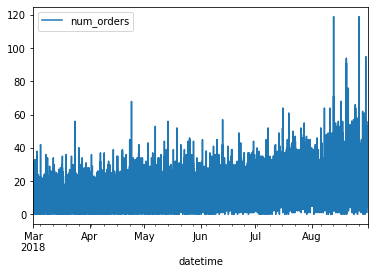

In [7]:
data.plot()

In [8]:
# resampling data kedalam 1 jam 

data = data.resample('1H').sum()
data.sample(10)

,num_orders
datetime,
2018-05-20 07:00:00,14
2018-07-11 02:00:00,152
2018-04-26 00:00:00,159
2018-08-11 07:00:00,33
2018-05-07 17:00:00,70
2018-05-11 00:00:00,107
2018-05-27 18:00:00,37
2018-05-11 06:00:00,52
2018-06-20 16:00:00,107


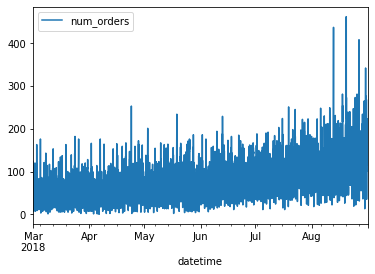

In [9]:
data.plot();

In [10]:
data.shape

(4416, 1)

**Catatan**

Dari langkah yang telah dilakukan diatas, ada beberapa catatan, berikut adalah catatanya:
1. Data yang dimiliki berupa data waktu dana data berapa banyak panngilan taksi setiap waktunya.
2. Tipe data pada kolom datetime masih berupa object, maka dari itu tipe data dirubah ke datetime dan dijadikan index.
3. Data yang ada dilakukan resampling ke perjam, agar dapat mudah menemukan berapa panggilan setiap jamnya.
4. Ukuran data sebelum resampling adalah 26496 baris dan 2 kolom. Setelah dilakukan resampling ukuran data menjadi 4416 baris dan 1 kolom. Lebih sederhana bukan.

## Analisis

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [12]:
decomposed = seasonal_decompose(data)
decomposed

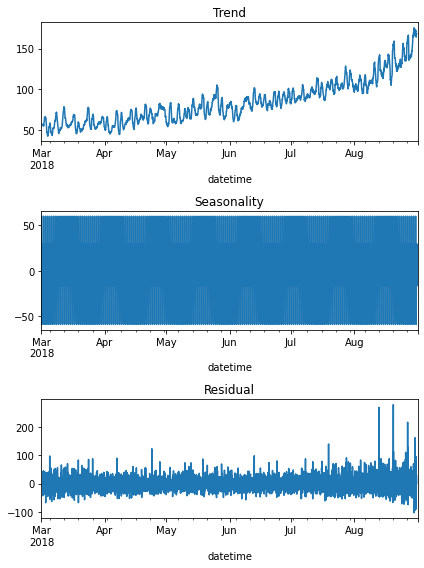

In [13]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residual')
plt.tight_layout()

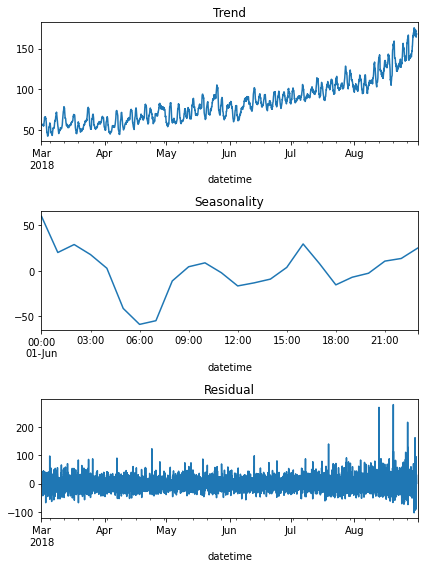

In [14]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['1 Jun 2018'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residual')
plt.tight_layout()

**Catatan**

Dari grafik trend yang ditampilkan, bahwa dari bulan maret hingga bulan agustus grafiknya mengalami kenaikan yang cukup jelas terlihat dan itu menandakan bahwa disetiap bulannya mengalami kenaikan dari segi panggilan taksi atau pesanan taksi yang ada. Pada grafik musiman, terlihat pada bulan agustus grafik mengalami kenaikan pada jam-jam kerja atau dapat dikatakan bahwa pada pagi hingga siang hari grafik mengalami fluktuasi naik dan turun namun pada jam malam hingga pukul 6 pagi garfik mengalami penurunan yang cukup tajam dan itu cukup masuk akal mengingat jam-jam tersebut bukan jam sibuk.

## Pelatihan

Sebelum melakukan pelatihan, mari lakukan pengoptimalan data dengan menambah beberapa fitur yang dapat memabantu proses pelatihan hingga pengujian.

In [15]:
def make_features(data, max_lag=4, rolling_mean_size=10):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (data['num_orders'].shift().rolling(rolling_mean_size).mean())

In [16]:
make_features(data)
data = data.dropna()
print(data.shape)

(4406, 10)


In [17]:
data.head(10)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,52.5
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,46.5
2018-03-01 12:00:00,30,3,1,3,12,96.0,64.0,69.0,34.0,47.6
2018-03-01 13:00:00,32,3,1,3,13,30.0,96.0,64.0,69.0,43.5
2018-03-01 14:00:00,48,3,1,3,14,32.0,30.0,96.0,64.0,40.1
2018-03-01 15:00:00,66,3,1,3,15,48.0,32.0,30.0,96.0,40.6
2018-03-01 16:00:00,43,3,1,3,16,66.0,48.0,32.0,30.0,46.6
2018-03-01 17:00:00,44,3,1,3,17,43.0,66.0,48.0,32.0,49.7
2018-03-01 18:00:00,73,3,1,3,18,44.0,43.0,66.0,48.0,52.6


**Catatan**

Data yang ada sudah berhasil ditambahkan beberapa fitur baru untuk menunjang proses pelatihan dan pengujian.

**Split Data**

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
train_valid, test = train_test_split(data, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

print(train.shape)
print(valid.shape)
print(test.shape)

(3568, 10)
(397, 10)
(441, 10)


In [20]:
print('train min and max:', train.index.min(), '-' , train.index.max())
print('valid min and max:', valid.index.min(), '-', valid.index.max())
print('test min and max:', test.index.min(), '-', test.index.max())

train min and max: 2018-03-01 10:00:00 - 2018-07-28 01:00:00
valid min and max: 2018-07-28 02:00:00 - 2018-08-13 14:00:00
test min and max: 2018-08-13 15:00:00 - 2018-08-31 23:00:00


In [21]:
# membuat fitur dan target pada ketiga dataset

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [22]:
print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)

(3568, 9) (3568,)
(397, 9) (397,)
(441, 9) (441,)


In [23]:
# membuat fungsi untuk rmse
from sklearn.metrics import mean_squared_error

def rmse(true, pred):
    return mean_squared_error(true, pred)**0.5

In [24]:
print('mean value:', test['num_orders'].mean())
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]

print('rmse prev:', rmse(test['num_orders'], pred_previous['num_orders']))
pred_mean = np.ones(test['num_orders'].shape) * train['num_orders'].mean()
print('rmse mean:', rmse(test['num_orders'], pred_mean))

mean value: 139.64172335600907
rmse prev: 58.82268986995932
rmse mean: 87.35030729608127


**1. LinearRegression**

In [25]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(features_train, target_train)

pred_train = lr.predict(features_train)
pred_valid = lr.predict(features_valid)

print('lr-rmse train:', rmse(target_train, pred_train))
print('lr-rmse valid:', rmse(target_valid, pred_valid))

lr-rmse train: 29.189032950503787
lr-rmse valid: 40.53857656513466


**2. Random Forest Regressor**

In [26]:
%%time

from sklearn.ensemble import RandomForestRegressor

max_depth = [2, 4, 6, 8, 10, 12]

for depth in max_depth:
    rf = RandomForestRegressor(max_depth=depth, n_estimators=100)
    rf.fit(features_train, target_train)
    
    pred_train = rf.predict(features_train)
    pred_valid = rf.predict(features_valid)
    
    
    print('depth:', depth)
    print('rf-rmse train:', rmse(target_train, pred_train))
    print('rf-rmse valid:', rmse(target_valid, pred_valid))

depth: 2
rf-rmse train: 28.566252011563495
rf-rmse valid: 47.85897646384376
depth: 4
rf-rmse train: 24.843819395123813
rf-rmse valid: 41.1016150675838
depth: 6
rf-rmse train: 21.19638422667562
rf-rmse valid: 35.51477954148297
depth: 8
rf-rmse train: 17.63554050736141
rf-rmse valid: 33.02483332858689
depth: 10
rf-rmse train: 14.27292886846983
rf-rmse valid: 32.40856327606419
depth: 12
rf-rmse train: 11.408971062733924
rf-rmse valid: 32.0849173558154
CPU times: user 6.55 s, sys: 114 ms, total: 6.67 s
Wall time: 6.72 s


**3. Decision Tree Regressor**

In [27]:
%%time

from sklearn.tree import DecisionTreeRegressor

max_depth = [1, 2, 4, 6, 8, 10]

for depth in max_depth:
    dtree = DecisionTreeRegressor(max_depth=depth)
    dtree.fit(features_train, target_train)
    
    pred_train = dtree.predict(features_train)
    pred_valid = dtree.predict(features_valid)
    
    print('depth:', depth)
    print('dtree-rmse train:', rmse(target_train, pred_train))
    print('dtree-rmse valid:', rmse(target_valid, pred_valid))
    

depth: 1
dtree-rmse train: 32.197381149282414
dtree-rmse valid: 51.101770444159214
depth: 2
dtree-rmse train: 29.40679602046847
dtree-rmse valid: 49.14518189970042
depth: 4
dtree-rmse train: 25.97971679152302
dtree-rmse valid: 43.16174960534505
depth: 6
dtree-rmse train: 22.37932961688169
dtree-rmse valid: 37.798431618398986
depth: 8
dtree-rmse train: 18.412214459165636
dtree-rmse valid: 33.82361617475039
depth: 10
dtree-rmse train: 14.79670502926706
dtree-rmse valid: 36.00492692153574
CPU times: user 110 ms, sys: 8.16 ms, total: 118 ms
Wall time: 127 ms


**4. LGBMRegressor**

In [28]:
%%time

from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(learning_rate=0.02, n_estimators=100, objective='rmse')
lgbm.fit(features_train, target_train, 
        eval_set=(features_valid, target_valid))

pred_train = lgbm.predict(features_train)
pred_valid = lgbm.predict(features_valid)

print('lgbm-rmse train:', rmse(target_train, pred_train))
print('lgbm-rmse valid:', rmse(target_valid, pred_valid))

[1]	valid_0's rmse: 57.2639
[2]	valid_0's rmse: 56.7064
[3]	valid_0's rmse: 56.1298
[4]	valid_0's rmse: 55.5829
[5]	valid_0's rmse: 55.0435
[6]	valid_0's rmse: 54.5197
[7]	valid_0's rmse: 53.9929
[8]	valid_0's rmse: 53.51
[9]	valid_0's rmse: 53.0407
[10]	valid_0's rmse: 52.5864
[11]	valid_0's rmse: 52.1281
[12]	valid_0's rmse: 51.668
[13]	valid_0's rmse: 51.2297
[14]	valid_0's rmse: 50.7866
[15]	valid_0's rmse: 50.3713
[16]	valid_0's rmse: 49.9744
[17]	valid_0's rmse: 49.557
[18]	valid_0's rmse: 49.1552
[19]	valid_0's rmse: 48.7643
[20]	valid_0's rmse: 48.394
[21]	valid_0's rmse: 48.0329
[22]	valid_0's rmse: 47.6832
[23]	valid_0's rmse: 47.3318
[24]	valid_0's rmse: 47.0128
[25]	valid_0's rmse: 46.7101
[26]	valid_0's rmse: 46.3896
[27]	valid_0's rmse: 46.0539
[28]	valid_0's rmse: 45.7437
[29]	valid_0's rmse: 45.4202
[30]	valid_0's rmse: 45.1026
[31]	valid_0's rmse: 44.8234
[32]	valid_0's rmse: 44.516
[33]	valid_0's rmse: 44.22
[34]	valid_0's rmse: 43.9504
[35]	valid_0's rmse: 43.7075
[3

**5. CatBoostRegressor**

In [29]:
%%time

from catboost import CatBoostRegressor

catboost = CatBoostRegressor(loss_function='RMSE', iterations=150, random_seed=12345)
catboost.fit(features_train, target_train, verbose=10)

pred_train = catboost.predict(features_train)
pred_valid = catboost.predict(features_valid)

print('catboost-rmse train:', rmse(target_train, pred_train))
print('catboost-rmse valid:', rmse(target_valid, pred_valid))

Learning rate set to 0.234046
0:	learn: 32.8572601	total: 51ms	remaining: 7.61s
10:	learn: 22.5354050	total: 74.8ms	remaining: 945ms
20:	learn: 21.1083596	total: 95.2ms	remaining: 585ms
30:	learn: 19.9366579	total: 119ms	remaining: 455ms
40:	learn: 19.1255679	total: 142ms	remaining: 378ms
50:	learn: 18.4219278	total: 165ms	remaining: 320ms
60:	learn: 17.8449850	total: 187ms	remaining: 273ms
70:	learn: 17.4016017	total: 210ms	remaining: 234ms
80:	learn: 16.9296442	total: 233ms	remaining: 199ms
90:	learn: 16.5131137	total: 261ms	remaining: 169ms
100:	learn: 16.0748939	total: 284ms	remaining: 138ms
110:	learn: 15.6022140	total: 307ms	remaining: 108ms
120:	learn: 15.2692033	total: 331ms	remaining: 79.2ms
130:	learn: 14.9064948	total: 354ms	remaining: 51.3ms
140:	learn: 14.4722475	total: 378ms	remaining: 24.2ms
149:	learn: 14.2233099	total: 400ms	remaining: 0us
catboost-rmse train: 14.223309867837282
catboost-rmse valid: 32.46793303374948
CPU times: user 390 ms, sys: 15.4 ms, total: 405 ms


**Catatan**

Dari hasil pelatihan yang telah dilakukan, berikut adalah beberapa catatanya:
1. Pada Linear Regression didapat:
    - lr-rmse train: 29.189032950503787
    - lr-rmse valid: 40.53857656513466

2. Pada Random Forest, nilai dengan rmse terbaik adalah:
    - max_depth: 12
        - rf-rmse train: 11.396990275039148
        - rf-rmse valid: 32.162405139072064

3. Pada Decision Tree, nilai dengan rmse terbaik adalah:
    - max_depth: 8
        - dtree-rmse train: 18.412214459165636
        - dtree-rmse valid: 33.79002629639206
4. Pada Lgbm didapat:
    - lgbm-rmse train: 20.240774679414994
    - lgbm-rmse valid: 34.981473604068704

5. Pada catboost didapat:
    - catboost-rmse train: 14.223309867837282
    - catboost-rmse valid: 32.46793303374948

## Pengujian

Pengujian data menggunakan test sample dengan ukuran 10% dari data.

In [30]:
features_train1 = train_valid.drop(['num_orders'], axis=1)
target_train1 = train_valid['num_orders']

In [41]:
%%time

lr = LinearRegression()
lr.fit(features_train1, target_train1)

pred_test = lr.predict(features_test)

print('lr-rmse test:', rmse(target_test, pred_test))


lr-rmse test: 53.17801688053662
CPU times: user 8.53 ms, sys: 4.06 ms, total: 12.6 ms
Wall time: 7.5 ms


In [42]:
%%time

rf = RandomForestRegressor(max_depth=12, n_estimators=100)
rf.fit(features_train1, target_train1)

pred_test = rf.predict(features_test)    

print('rf-rmse train:', rmse(target_test, pred_test))


rf-rmse train: 46.320548534841706
CPU times: user 1.84 s, sys: 3.45 ms, total: 1.85 s
Wall time: 1.84 s


In [43]:
%%time

dtree = DecisionTreeRegressor(max_depth=8)
dtree.fit(features_train1, target_train1)
    
pred_test = dtree.predict(features_test)
    
print('dtree-rmse train:', rmse(target_test, pred_test))


dtree-rmse train: 56.097306244394375
CPU times: user 21.4 ms, sys: 3.83 ms, total: 25.2 ms
Wall time: 23.4 ms


In [44]:
%%time

lgbm = LGBMRegressor(learning_rate=0.02, n_estimators=100, objective='rmse')
lgbm.fit(features_train1, target_train1, 
        eval_set=(features_test, target_test))

pred_test = lgbm.predict(features_test)


print('lgbm-rmse train:', rmse(target_test, pred_test))


[1]	valid_0's rmse: 83.9298
[2]	valid_0's rmse: 83.0992
[3]	valid_0's rmse: 82.2841
[4]	valid_0's rmse: 81.5325
[5]	valid_0's rmse: 80.7983
[6]	valid_0's rmse: 80.0278
[7]	valid_0's rmse: 79.3522
[8]	valid_0's rmse: 78.5886
[9]	valid_0's rmse: 77.8271
[10]	valid_0's rmse: 77.1771
[11]	valid_0's rmse: 76.4336
[12]	valid_0's rmse: 75.84
[13]	valid_0's rmse: 75.2447
[14]	valid_0's rmse: 74.7736
[15]	valid_0's rmse: 74.2304
[16]	valid_0's rmse: 73.7748
[17]	valid_0's rmse: 73.2811
[18]	valid_0's rmse: 72.794
[19]	valid_0's rmse: 72.2137
[20]	valid_0's rmse: 71.7344
[21]	valid_0's rmse: 71.232
[22]	valid_0's rmse: 70.745
[23]	valid_0's rmse: 70.3271
[24]	valid_0's rmse: 69.806
[25]	valid_0's rmse: 69.4062
[26]	valid_0's rmse: 68.9639
[27]	valid_0's rmse: 68.4676
[28]	valid_0's rmse: 68.0267
[29]	valid_0's rmse: 67.5603
[30]	valid_0's rmse: 67.2202
[31]	valid_0's rmse: 66.8189
[32]	valid_0's rmse: 66.3719
[33]	valid_0's rmse: 65.9565
[34]	valid_0's rmse: 65.5299
[35]	valid_0's rmse: 65.2018


In [45]:
%%time

catboost = CatBoostRegressor(loss_function='RMSE', iterations=150, random_seed=12345)
catboost.fit(features_train1, target_train1, verbose=10)

pred_test = catboost.predict(features_test)

print('catboost-rmse valid:', rmse(target_test, pred_test))

Learning rate set to 0.23798
0:	learn: 34.4291417	total: 2.78ms	remaining: 414ms
10:	learn: 24.0356842	total: 28.4ms	remaining: 359ms
20:	learn: 22.5309142	total: 53.4ms	remaining: 328ms
30:	learn: 21.2650320	total: 77.7ms	remaining: 298ms
40:	learn: 20.3194826	total: 102ms	remaining: 272ms
50:	learn: 19.5887833	total: 127ms	remaining: 246ms
60:	learn: 18.8771254	total: 152ms	remaining: 221ms
70:	learn: 18.1554463	total: 177ms	remaining: 197ms
80:	learn: 17.6508898	total: 202ms	remaining: 172ms
90:	learn: 17.2290483	total: 230ms	remaining: 149ms
100:	learn: 16.8021924	total: 255ms	remaining: 124ms
110:	learn: 16.3546127	total: 285ms	remaining: 100ms
120:	learn: 16.0062018	total: 314ms	remaining: 75.2ms
130:	learn: 15.6718208	total: 339ms	remaining: 49.1ms
140:	learn: 15.3650223	total: 363ms	remaining: 23.2ms
149:	learn: 15.2088057	total: 386ms	remaining: 0us
catboost-rmse valid: 44.30780376251568
CPU times: user 403 ms, sys: 3.79 ms, total: 407 ms
Wall time: 493 ms


**KEIMPULAN**

Ada beberapa kesimpulan yang dapat diambil dari hasil pengujian yang telah dilakukan, diantaranyan:

1. Pada model LinearRegression nilai rmse pada pengujian test set adalah 53.17801688053662 dengan waktu prediksi 7.5 ms.
2. Pada model RandomForest nilai rmse pada pengujian test set adalah 46.320548534841706 dengan waktu prediksi 1.84 s.
3. Pada model DecisionTree nilai rmse pada pengujian test set adalah 56.097306244394375 dengan waktu prediksi 23.4 ms.
4. Pada model Gradient Boosting menggunakan LgbmRegressor nilai rmse pada pengujian test set adalah 52.30280965201199 dengan waktu prediksi 1.88 s.
5. Pada model Gradient Boosting menggunakan CatBoosting nilai rmse pada pengujian test set adalah 44.30780376251568 dengan waktu prediksi 493 ms.
6. Dari ke 5 model yang telah dilakukan pengujian pada testset, nilai rmse yang memiliki nilai dibawah 48 ada 2 model yaitu:
    - Model RandomForest dengan nilai rmse: 46.320548534841706 dengan waktu prediksi 1.84 s.
    - Model Gradient Boosting menggunakan CatBoosting dengan nilai rmse: 44.30780376251568 dengan waktu prediksi 493 ms.
7. Hasil model terbaik yang dilakukan pada test set adalah model dengan gradient boosting menggunkaan Catboosting. Model ini juga adalah model dengan waktu tercepat untuk prediksi.

# Daftar Periksa Penilaian

- [x]  Jupyter Notebook bisa dibuka.
- [ ]  Tidak ada kesalahan dalam kode
- [ ]  Sel-sel dengan kode telah disusun berdasarkan urutan eksekusi.
- [ ]  Data telah diunduh dan disiapkan
- [ ]  Data telah dianalisis
- [ ]  Model sudah dilatih dan hiperparameter sudah dipilih
- [ ]  Model sudah dievaluasi. Kesimpulan sudah ada.
- [ ] *RMSE* untuk *test set* tidak lebih dari 48